In [1]:
!pip install split-folders

### **Importing of Necessary Libraries**

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random
import cv2
import os
import PIL
import pathlib
import splitfolders

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16

### **Dataset Loading and Splitting**
Split-folders library was used to split the dataset into three parts: Training set(70%), Validation set(15%), and Test set(15%).

In [3]:
base_ds = '../input/rice-image-dataset/Rice_Image_Dataset'
base_ds = pathlib.Path(base_ds)

In [4]:
splitfolders.ratio(base_ds, output='imgs', seed=123, ratio=(.7,.15,.15), group_prefix=None)

Copying files: 75000 files [11:09, 112.05 files/s]


In [5]:
arborio = [fn for fn in os.listdir(f'{base_ds}/Arborio') if fn.endswith('.jpg')]
bastmati = [fn for fn in os.listdir(f'{base_ds}/Basmati') if fn.endswith('.jpg')]
ipsala = [fn for fn in os.listdir(f'{base_ds}/Ipsala') if fn.endswith('.jpg')]
jasmine = [fn for fn in os.listdir(f'{base_ds}/Jasmine') if fn.endswith('.jpg')]
karacadag = [fn for fn in os.listdir(f'{base_ds}/Karacadag') if fn.endswith('.jpg')]
rice = [arborio, bastmati, ipsala, jasmine, karacadag]
rice_classes = []
for i in os.listdir('imgs/train'):
    rice_classes+=[i]
rice_classes.sort()

### **Dataset Exploration**
It can be seen here the total number of images in the dataset, the number of classes, and how well the images from each variety is distributed

Total images: 75000
Total number of classes: 5
Total Arborio images: 15000
Total Basmati images: 15000
Total Ipsala images: 15000
Total Jasmine images: 15000
Total Karacadag images: 15000


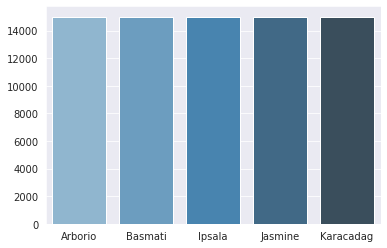

In [6]:
image_count = len(list(base_ds.glob('*/*.jpg')))
print(f'Total images: {image_count}')
print(f'Total number of classes: {len(rice_classes)}')
count = 0
rice_count = []
for x in rice_classes:
  print(f'Total {x} images: {len(rice[count])}')
  rice_count.append(len(rice[count]))
  count += 1

sns.set_style('darkgrid')
sns.barplot(x=rice_classes, y=rice_count, palette="Blues_d")
plt.show()

### Sample Images
Each image from the dataset has a dimension of 250 by 250 and a color type of RGB

Image dimensions: (250, 250, 3)


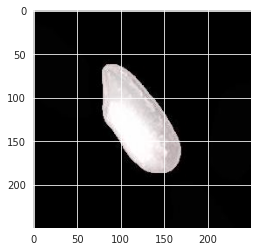

In [7]:
sample_img = cv2.imread('imgs/test/Arborio/Arborio (10).jpg')
plt.imshow(sample_img)
print(f'Image dimensions: {sample_img.shape}')

In [8]:
def load_random_img(dir, label):
  plt.figure(figsize=(10,10))
  i=0
  for label in rice_classes:
    i+=1
    plt.subplot(1, 5, i)
    file = random.choice(os.listdir(f'{dir}/{label}'))
    image_path = os.path.join(f'{dir}/{label}', file)
    img=cv2.imread(image_path)
    plt.title(label)
    plt.imshow(img)
    plt.grid(None)
    plt.axis('off')

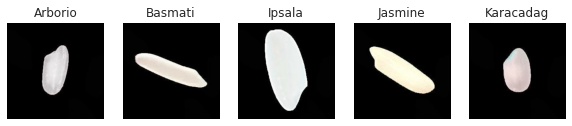

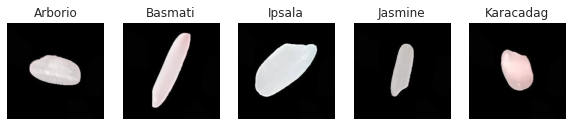

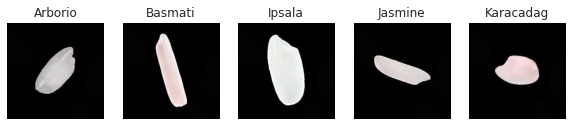

In [9]:
for i in range(3):
  load_random_img(base_ds, rice_classes)

In [10]:
batch_size = 128
img_height, img_width = 175, 175
input_shape = (img_height, img_width, 3)

### **Data Pre-processing**

In [11]:
datagen = ImageDataGenerator(rescale=1./255)

In [12]:
train_ds = datagen.flow_from_directory(
    'imgs/train',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    subset = "training",
    class_mode='categorical')

val_ds = datagen.flow_from_directory(
    'imgs/val',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode='categorical',
    shuffle=False)

test_ds = datagen.flow_from_directory(
    'imgs/test',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode='categorical',
    shuffle=False)

Found 52500 images belonging to 5 classes.
Found 11250 images belonging to 5 classes.
Found 11250 images belonging to 5 classes.


In [13]:
def plot_train_history(history):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

## **Vanilla CNN Model**

In [14]:
model_vanilla = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32,(3,3), activation='relu', input_shape=input_shape),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(axis = 3),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2),padding='same'),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(axis = 3),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2),padding='same'),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(axis = 3),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2),padding='same'),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(5, activation='softmax')
])

2022-12-26 00:53:24.165244: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-26 00:53:24.250733: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-26 00:53:24.251483: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-26 00:53:24.252644: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [15]:
model_vanilla.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_vanilla.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 173, 173, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 173, 173, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 173, 173, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 173, 173, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 87, 87, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 87, 87, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 87, 87, 64)        1

## **Callbacks**

In [16]:
models_dir = "saved_models"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

checkpointer = ModelCheckpoint(filepath='saved_models/model_vanilla.hdf5', 
                               monitor='val_accuracy', mode='max',
                               verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=0.001)
callbacks=[early_stopping, reduce_lr, checkpointer]

In [17]:
history1 = model_vanilla.fit(train_ds, epochs = 40, validation_data = val_ds, callbacks=callbacks)

2022-12-26 00:53:37.952846: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/40


2022-12-26 00:53:40.090773: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


411/411 [==============================] - 151s 345ms/step - loss: 0.1008 - accuracy: 0.9665 - val_loss: 9.2601 - val_accuracy: 0.3769

Epoch 00001: val_accuracy improved from -inf to 0.37689, saving model to saved_models/model_vanilla.hdf5
Epoch 2/40
411/411 [==============================] - 141s 343ms/step - loss: 0.0354 - accuracy: 0.9883 - val_loss: 0.4360 - val_accuracy: 0.8651

Epoch 00002: val_accuracy improved from 0.37689 to 0.86507, saving model to saved_models/model_vanilla.hdf5
Epoch 3/40
411/411 [==============================] - 141s 342ms/step - loss: 0.0275 - accuracy: 0.9911 - val_loss: 0.0536 - val_accuracy: 0.9821

Epoch 00003: val_accuracy improved from 0.86507 to 0.98213, saving model to saved_models/model_vanilla.hdf5
Epoch 4/40
411/411 [==============================] - 141s 343ms/step - loss: 0.0197 - accuracy: 0.9938 - val_loss: 0.0484 - val_accuracy: 0.9837

Epoch 00004: val_accuracy improved from 0.98213 to 0.98373, saving model to saved_models/model_vanilla

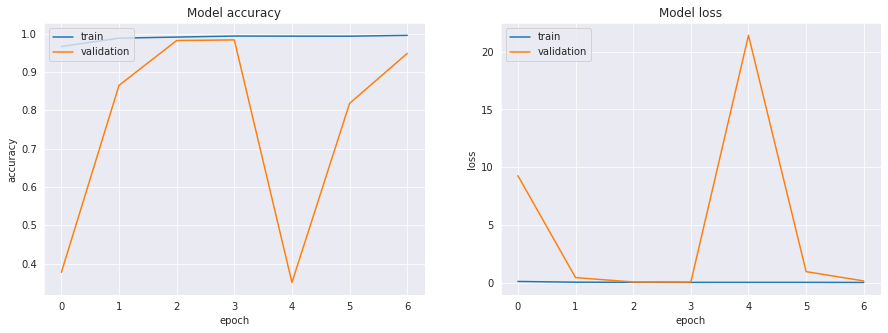

In [18]:
model_vanilla.load_weights('saved_models/model_vanilla.hdf5')
plot_train_history(history1)

## **Model Evaluation of Vanilla CNN**

In [19]:
score1 = model_vanilla.evaluate(test_ds, verbose=1)

88/88 [==============================] - 21s 239ms/step - loss: 0.0523 - accuracy: 0.9837


In [20]:
from sklearn.metrics import classification_report, confusion_matrix

Y_pred = model_vanilla.predict(test_ds)

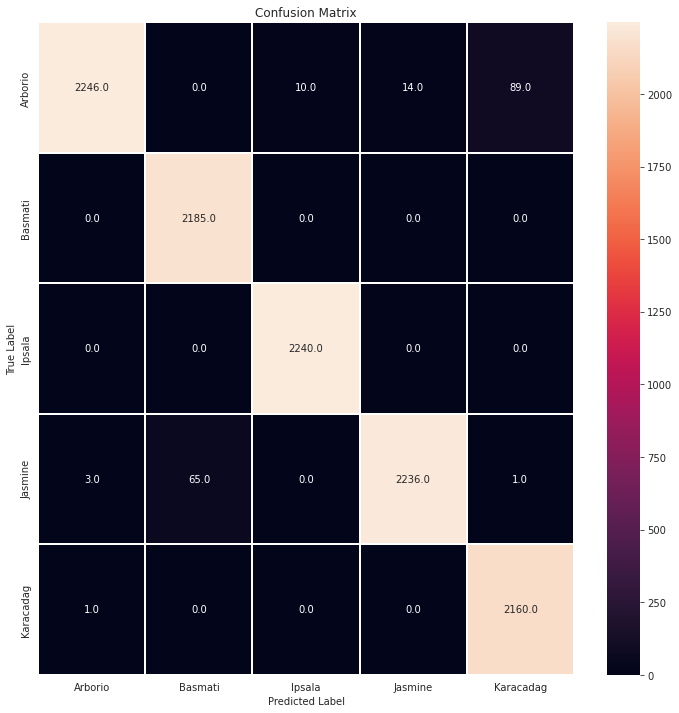

In [21]:
y_pred = np.argmax(Y_pred, axis=1)
confusion_mtx = confusion_matrix(y_pred, test_ds.classes)
f,ax = plt.subplots(figsize=(12, 12))
sns.heatmap(confusion_mtx, annot=True, 
            linewidths=0.01,
            linecolor="white", 
            fmt= '.1f',ax=ax,)
sns.color_palette("rocket", as_cmap=True)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(test_ds.class_indices)
ax.yaxis.set_ticklabels(rice_classes)
plt.title("Confusion Matrix")
plt.show()

In [22]:
report1 = classification_report(test_ds.classes, y_pred, target_names=rice_classes, output_dict=True)
df1 = pd.DataFrame(report1).transpose()
df1

,precision,recall,f1-score,support
Arborio,0.952098,0.998222,0.974615,2250.000000
Basmati,1.000000,0.971111,0.985344,2250.000000
Ipsala,1.000000,0.995556,0.997773,2250.000000
Jasmine,0.970065,0.993778,0.981778,2250.000000
Karacadag,0.999537,0.960000,0.979370,2250.000000
accuracy,0.983733,0.983733,0.983733,0.983733
macro avg,0.984340,0.983733,0.983776,11250.000000
weighted avg,0.984340,0.983733,0.983776,11250.000000


## **Transfer Learning**

In [23]:
vgg16 = VGG16(weights="imagenet", include_top=False, input_shape=input_shape)
vgg16.trainable = False
inputs = tf.keras.Input(input_shape)
x = vgg16(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(5, activation='softmax')(x)
model_vgg16 = tf.keras.Model(inputs, x)

58900480/58889256 [==============================] - 2s 0us/step


In [24]:
model_vgg16.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_vgg16.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 175, 175, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 5, 5, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 5125      
Total params: 15,245,125
Trainable params: 530,437
Non-trainable params: 14,714,688
_________________________________________________________________


In [25]:
checkpointer = ModelCheckpoint(filepath='saved_models/model_vgg16.hdf5', 
                               monitor='val_accuracy', mode='max',
                               verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=0.001)
callbacks=[early_stopping, reduce_lr, checkpointer]

In [26]:
history2 = model_vgg16.fit(train_ds, epochs = 40, validation_data = val_ds, callbacks=callbacks)

Epoch 1/40
411/411 [==============================] - 153s 356ms/step - loss: 0.1643 - accuracy: 0.9568 - val_loss: 0.0495 - val_accuracy: 0.9868

Epoch 00001: val_accuracy improved from -inf to 0.98676, saving model to saved_models/model_vgg16.hdf5
Epoch 2/40
411/411 [==============================] - 140s 340ms/step - loss: 0.0448 - accuracy: 0.9862 - val_loss: 0.0420 - val_accuracy: 0.9872

Epoch 00002: val_accuracy improved from 0.98676 to 0.98720, saving model to saved_models/model_vgg16.hdf5
Epoch 3/40
411/411 [==============================] - 141s 342ms/step - loss: 0.0339 - accuracy: 0.9892 - val_loss: 0.0248 - val_accuracy: 0.9924

Epoch 00003: val_accuracy improved from 0.98720 to 0.99244, saving model to saved_models/model_vgg16.hdf5
Epoch 4/40
411/411 [==============================] - 140s 341ms/step - loss: 0.0278 - accuracy: 0.9910 - val_loss: 0.0395 - val_accuracy: 0.9863

Epoch 00004: val_accuracy did not improve from 0.99244
Epoch 5/40
411/411 [======================

In [27]:
model_vgg16.load_weights('saved_models/model_vgg16.hdf5')

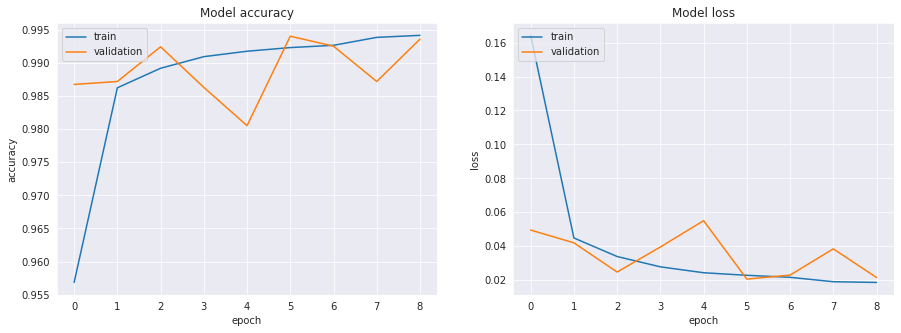

In [28]:
plot_train_history(history2)

In [29]:
score2 = model_vgg16.evaluate(test_ds, verbose=1)
print(f'Model 1 Vanilla Loss: {score1[0]}, Accuracy: {score1[1]*100}')
print(f'Model 2 VGG16 Loss: {score2[0]}, Accuracy: {score2[1]*100}')

88/88 [==============================] - 24s 270ms/step - loss: 0.0207 - accuracy: 0.9934
Model 1 Vanilla Loss: 0.05225733667612076, Accuracy: 98.37333559989929
Model 2 VGG16 Loss: 0.02066286839544773, Accuracy: 99.34222102165222


## **Fine Tuning**

In [30]:
vgg16.trainable = True
model_vgg16.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy', metrics=['accuracy'])

In [31]:
history3 = model_vgg16.fit(train_ds, epochs = 40, validation_data = val_ds, callbacks=callbacks)

Epoch 1/40
411/411 [==============================] - 234s 563ms/step - loss: 0.0149 - accuracy: 0.9953 - val_loss: 0.0083 - val_accuracy: 0.9978

Epoch 00001: val_accuracy improved from 0.99404 to 0.99778, saving model to saved_models/model_vgg16.hdf5
Epoch 2/40
411/411 [==============================] - 230s 560ms/step - loss: 0.0066 - accuracy: 0.9977 - val_loss: 0.0285 - val_accuracy: 0.9926

Epoch 00002: val_accuracy did not improve from 0.99778
Epoch 3/40
411/411 [==============================] - 230s 560ms/step - loss: 0.0044 - accuracy: 0.9986 - val_loss: 0.0089 - val_accuracy: 0.9979

Epoch 00003: val_accuracy improved from 0.99778 to 0.99787, saving model to saved_models/model_vgg16.hdf5
Epoch 4/40
411/411 [==============================] - 231s 561ms/step - loss: 0.0067 - accuracy: 0.9982 - val_loss: 0.0061 - val_accuracy: 0.9986

Epoch 00004: val_accuracy improved from 0.99787 to 0.99858, saving model to saved_models/model_vgg16.hdf5
Epoch 5/40
411/411 [===================

In [32]:
model_vgg16.load_weights('saved_models/model_vgg16.hdf5')

## **Final Evaluation**

In [33]:
score3 = model_vgg16.evaluate(test_ds, verbose=1)
print(f'Model 1 Vanilla Loss: {score1[0]}, Accuracy: {score1[1]*100}')
print(f'Model 2 VGG16 Loss: {score2[0]}, Accuracy: {score2[1]*100}')
print(f'Model 2 VGG16 Fine-tuned Loss: {score3[0]}, Accuracy: {score3[1]*100}')

88/88 [==============================] - 24s 269ms/step - loss: 0.0031 - accuracy: 0.9988
Model 1 Vanilla Loss: 0.05225733667612076, Accuracy: 98.37333559989929
Model 2 VGG16 Loss: 0.02066286839544773, Accuracy: 99.34222102165222
Model 2 VGG16 Fine-tuned Loss: 0.003115386236459017, Accuracy: 99.88444447517395


In [34]:
Y_pred = model_vgg16.predict(test_ds)

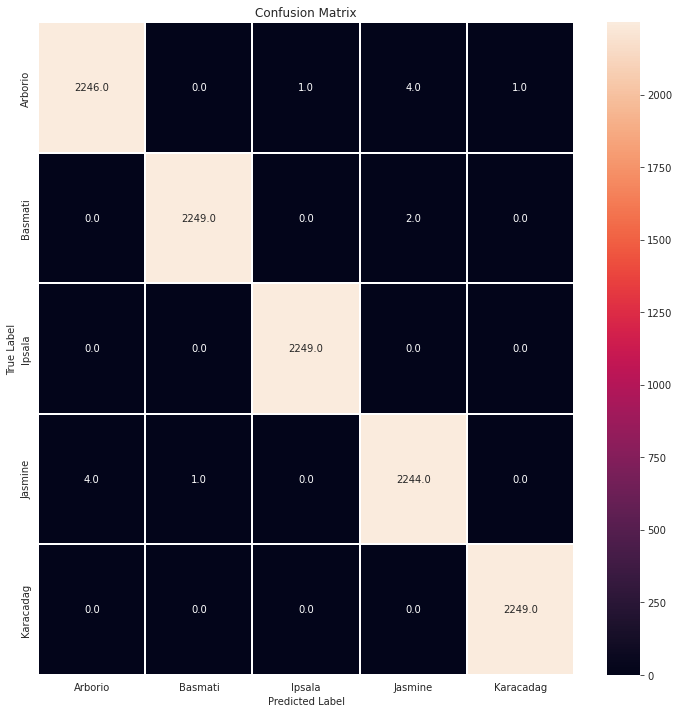

In [35]:
y_pred = np.argmax(Y_pred, axis=1)
confusion_mtx = confusion_matrix(y_pred, test_ds.classes)
f,ax = plt.subplots(figsize=(12, 12))
sns.heatmap(confusion_mtx, annot=True, 
            linewidths=0.01,
            linecolor="white", 
            fmt= '.1f',ax=ax,)
sns.color_palette("rocket", as_cmap=True)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(test_ds.class_indices)
ax.yaxis.set_ticklabels(rice_classes)
plt.title("Confusion Matrix")
plt.show()

In [36]:
report2 = classification_report(test_ds.classes, y_pred, target_names=rice_classes, output_dict=True)
df2 = pd.DataFrame(report1).transpose()
df2

,precision,recall,f1-score,support
Arborio,0.952098,0.998222,0.974615,2250.000000
Basmati,1.000000,0.971111,0.985344,2250.000000
Ipsala,1.000000,0.995556,0.997773,2250.000000
Jasmine,0.970065,0.993778,0.981778,2250.000000
Karacadag,0.999537,0.960000,0.979370,2250.000000
accuracy,0.983733,0.983733,0.983733,0.983733
macro avg,0.984340,0.983733,0.983776,11250.000000
weighted avg,0.984340,0.983733,0.983776,11250.000000


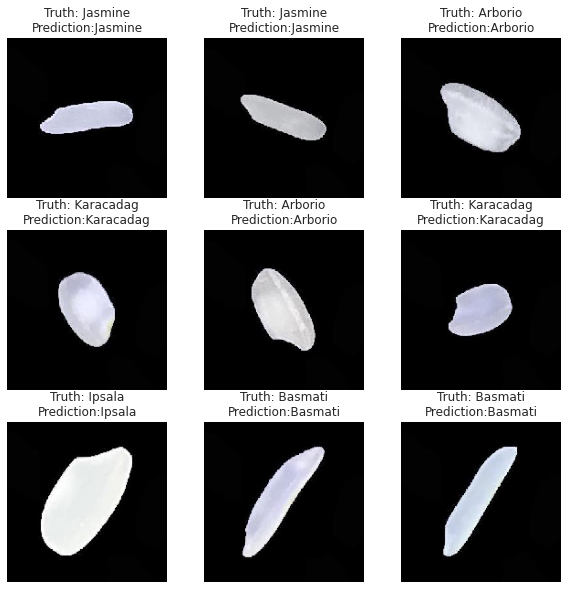

In [37]:
plt.figure(figsize=(10, 10))
x, label= train_ds.next()
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(x[i])
    result = np.where(label[i]==1)
    predict = model_vgg16(tf.expand_dims(x[i], 0))
    score = tf.nn.softmax(predict[0])
    score_label = rice_classes[np.argmax(score)]
    plt.title(f'Truth: {rice_classes[result[0][0]]}\nPrediction:{score_label}')
    plt.axis(False)